<a href="https://colab.research.google.com/github/GrigoryBartosh/hse08_ip/blob/master/hw4_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/ip_hw_4'

/content/drive/My Drive/ip_hw_4


In [3]:
pip install NearPy

In [0]:
import os
import copy
import zipfile
import time

import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
import cv2

from PIL import Image

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.cm as cm

PATH_DATASET = 'Corel.zip'
PATH_TEST = 'test.dat'

In [5]:
with open(PATH_TEST, 'rb') as file:
    file_names = file.readlines()
    test_image_nums = [f.strip()[:-5] for f in file_names]
    test_image_nums = list(map(int, test_image_nums))

test_image_nums = set(test_image_nums)

train_images, test_images = [], []
train_labels, test_labels = [], []
with zipfile.ZipFile(PATH_DATASET, 'r') as zip_file:
    file_paths = zip_file.namelist()
    file_paths = list(filter(lambda f: f.endswith('jpg'), file_paths))
    file_paths = [(f, int(f[:-4].split('_')[1])) for f in file_paths]
    file_paths.sort(key=lambda x: x[1])

    for file_path, num in tqdm(file_paths):
        with zip_file.open(os.path.join(file_path)) as img_file:
            image = Image.open(img_file).convert('RGB')
            image = np.array(image, dtype=np.float32)

        cls = num // 100

        if num in test_image_nums:
            test_images += [image]
            test_labels += [cls]
        else:
            train_images += [image]
            train_labels += [cls]

test_labels = np.array(test_labels, dtype=np.int32)
train_labels = np.array(train_labels, dtype=np.int32)

In [0]:
def show_space(xs, ys, cs=None):
    if cs is not None:
        points = np.concatenate((xs, cs), axis=0)
    else:
        points = xs

    points_embedded = TSNE(n_components=2).fit_transform(points)

    xs = points_embedded[:len(xs)]
    if cs is not None:
        cs = points_embedded[-len(cs):]

    colors = cm.rainbow(np.linspace(0, 1, max(ys) + 1))
    for x, y in zip(xs, ys):
        plt.scatter([x[0]], [x[1]], marker='.', color=colors[y])

    if cs is not None:
        plt.scatter(cs[:, 0], cs[:, 1], marker='x', color='black')

    plt.show()

In [0]:
class GIST:
    ORIENTATIONS = 3
    SCALES = 1

    def __init__(self):
        self._kernels = [
            self._build_gabor_kernel(theta)
            for theta in np.arange(0, np.pi, np.pi / GIST.ORIENTATIONS)
        ]

    def _build_gabor_kernel(self, theta):
        return cv2.getGaborKernel(
            ksize=(3, 3),
            sigma=7,
            theta=theta,
            lambd=10.0,
            gamma=0.5,
            psi=0
        )

    def calc(self, image):
        image = cv2.resize(image, (256, 256))

        x = []
        for _ in range(GIST.SCALES):
            h, w, _ = image.shape
            for kernel in self._kernels:
                res = cv2.filter2D(image, ddepth=-1, kernel=kernel)
                res = res.reshape(4, h // 4, 4, w // 4, 3)
                res = res.sum(axis=3).sum(axis=1)
                res = res.reshape(-1)
                x += [res]

            image = cv2.resize(image, (w // 2, h // 2))

        return np.concatenate(x, axis=0)

In [0]:
class MyKMeans:
    N_CLUSTERS = 8

    def __init__(self, xs):
        self._kmeans = KMeans(
            n_clusters=MyKMeans.N_CLUSTERS,
            init='k-means++',
            max_iter=300,
            n_init=10
        )
        self._kmeans.fit(xs)

    def get_centers(self):
        return self._kmeans.cluster_centers_
    
    def predict(self, xs):
        if len(xs.shape) == 1:
            xs = xs.reshape(1, -1)
            
        return self._kmeans.predict(xs)

In [0]:
class LSH:
    DIM = 4

    def __init__(self, xs, ys):
        rbp = RandomBinaryProjections('rbp', LSH.DIM)
        self._engine = Engine(xs.shape[1], lshashes=[rbp])
        for i, (x, y) in enumerate(zip(xs, ys)):
            self._engine.store_vector(x, y)
    
    def predict(self, x):
        res = self._engine.neighbours(x)
        res.sort(key=lambda t: t[2])
        return [n for _, n, _ in res]

In [0]:
class IndexSimpleL2:
    K = 10

    def __init__(self, images):
        self._gist = GIST()

        self._xs = [self._gist.calc(x) for x in tqdm(images)]
        self._xs = np.stack(self._xs, axis=0)

    def retrieve(self, image):
        x = self._gist.calc(image)

        dists = ((self._xs - x[np.newaxis, :]) ** 2).sum(axis=1)
        ids = np.argpartition(dists, IndexSimpleL2.K)

        return ids[:IndexSimpleL2.K]

In [0]:
class IndexKMeansLSH:
    def __init__(self, images):
        self._gist = GIST()

        xs = [self._gist.calc(x) for x in tqdm(images)]
        xs = np.stack(xs, axis=0)

        self._kmeans = MyKMeans(xs)
        n_clusters = len(self._kmeans.get_centers())

        self._lsh = []
        ys = self._kmeans.predict(xs)
        for i in range(n_clusters):
            ids = np.where(ys == i)[0]
            self._lsh += [LSH(xs[ids], ids)]

    def retrieve(self, image):
        x = self._gist.calc(image)

        cluster = self._kmeans.predict(x)[0]
        return self._lsh[cluster].predict(x)

In [0]:
def calc_ap(labels, label):
    K = 10

    if len(labels) < K:
        labels = np.concatenate((labels, 
                                 np.full((K - len(labels),), -1)), 
                                axis=0)
    labels = labels[:K]

    results = (labels == label)
    precisions = np.cumsum(results) / np.arange(1, K + 1)

    return precisions.mean()

In [0]:
def show_retrieve(index, images, labels, image, label):
    st = time.time()
    ids = index.retrieve(image)
    st = time.time() - st

    ap = calc_ap(labels[ids], label)

    res_images = [images[i] for i in ids]
    h = max([img.shape[0] for img in res_images])
    res_images = [cv2.resize(img, (img.shape[1] * h // img.shape[0], h))
                  for img in res_images]
    res_images = np.concatenate(res_images, axis=1)

    plt.imshow(image / 255)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(30, 30))
    plt.imshow(res_images / 255)
    plt.axis('off')
    plt.show()

    print('Retrieve time: {:.3f}s'.format(st))
    print(f'AP@10: {ap}')

In [0]:
def evaluate_index(index, labels, test_images, test_labels):
    lst = []
    lap = []
    for image, label in tqdm(zip(test_images, test_labels)):
        st = time.time()
        ids = index.retrieve(image)
        st = time.time() - st

        ap = calc_ap(labels[ids], label)

        lst += [st]
        lap += [ap]

    st = sum(lst) / len(lst)
    ap = sum(lap) / len(lap)

    print('Mean retrieve time: {:.3f}s'.format(st))
    print(f'MAP@10: {ap}')

In [0]:
def full_task(index_type, train_images, train_labels, test_images, test_labels):
    st = time.time()
    index = index_type(train_images)
    st = time.time() - st

    print('Build time: {:.3f}s'.format(st))

    ids = np.random.choice(len(test_images), 5, replace=False)
    for i in ids:
        show_retrieve(index, 
                      train_images, train_labels,
                      test_images[i], test_labels[i])

    evaluate_index(index, train_labels, test_images, test_labels)


Build time: 58.772s


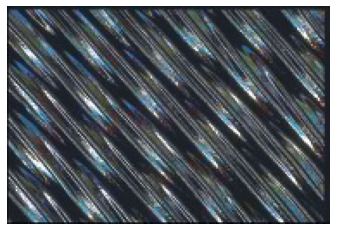

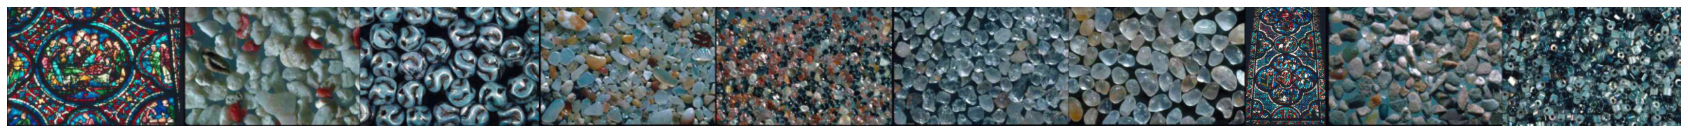

Retrieve time: 0.014s
AP@10: 0.0


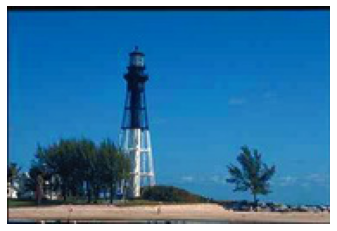

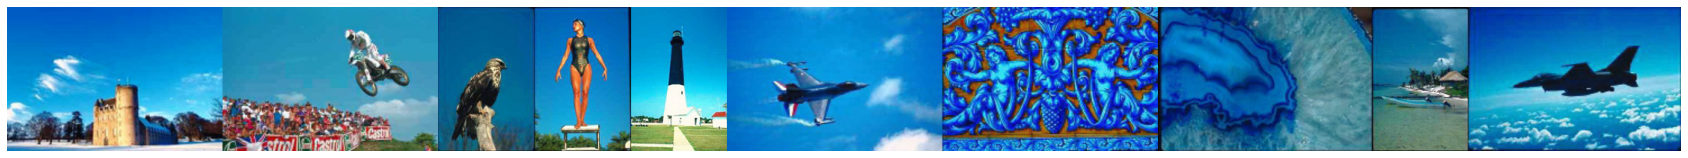

Retrieve time: 0.013s
AP@10: 0.08456349206349206


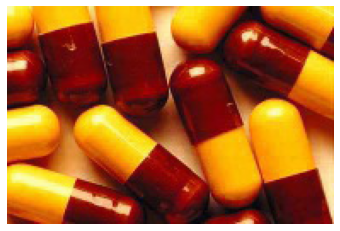

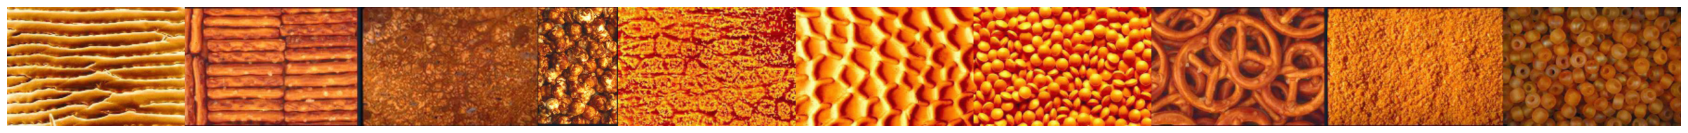

Retrieve time: 0.018s
AP@10: 0.047896825396825396


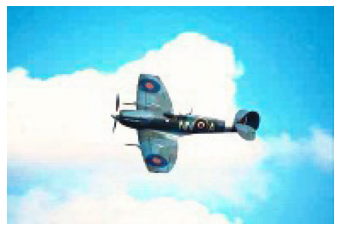

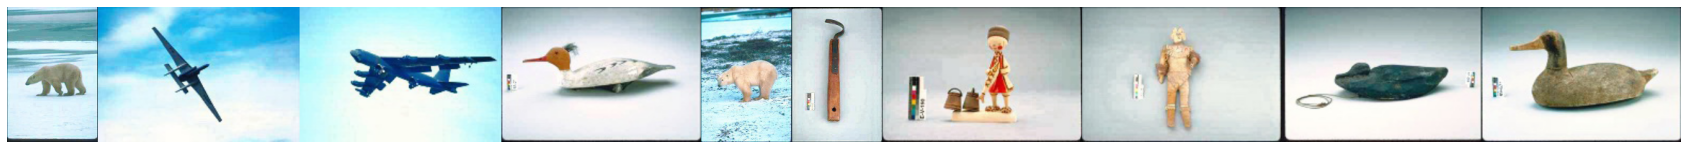

Retrieve time: 0.013s
AP@10: 0.3357936507936508


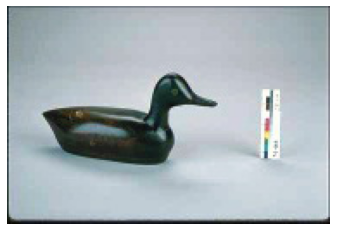

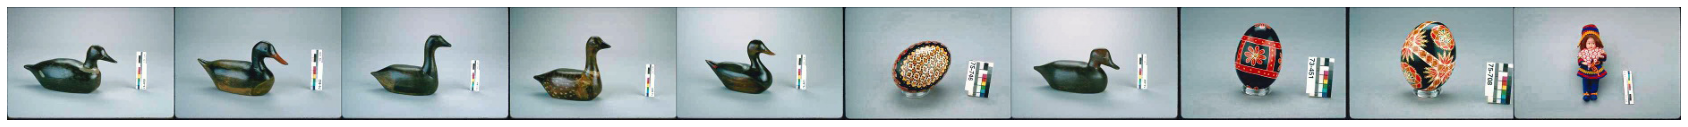

Retrieve time: 0.014s
AP@10: 0.8707142857142858



Mean retrieve time: 0.009s
MAP@10: 0.2498918650793653


In [16]:
full_task(IndexKMeansLSH,
          train_images, train_labels,
          test_images, test_labels)